In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings("ignore")

In [3]:
import plotly
from plotly.offline import iplot
import plotly.graph_objs as go

In [4]:
plotly.offline.init_notebook_mode(connected=True)

# Get MNIST dataset

In [5]:
batch_size = 100

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])

In [7]:
trainset = torchvision.datasets.MNIST(root='./data',  train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

In [8]:
testset = torchvision.datasets.MNIST(root='./data',  train=False,  download=True,  transform=transform)
testloader = torch.utils.data.DataLoader(testset,  batch_size=len(testset), shuffle=False,  num_workers=2)

In [9]:
classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

# Display

In [10]:
data_list = np.array([])
label_list = []
for i in range(1000):
    data = trainset[i]
    data_list = np.append(data_list, data[0].detach().numpy())
    label_list.append(data[1])

In [11]:
data_list = np.reshape(data_list, (1000, 1, 28, 28))

In [12]:
print(f"len_trainset : {len(trainset)}")
print(f"len_testset : {len(testset)}")

len_trainset : 60000
len_testset : 10000


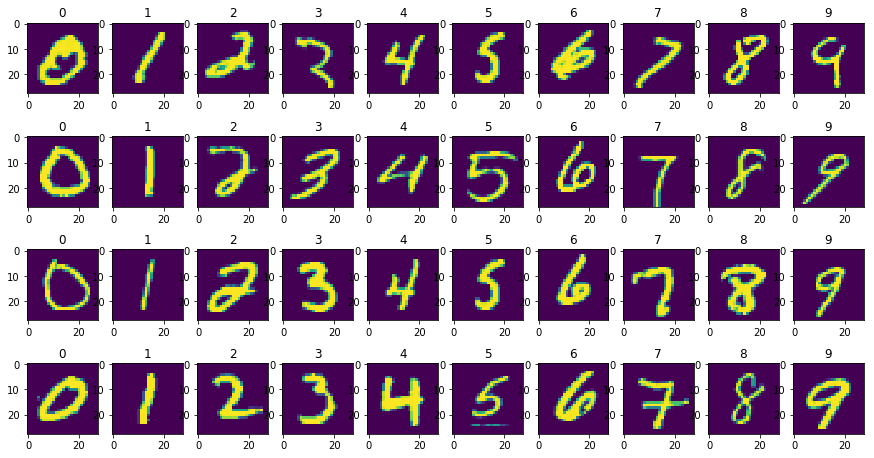

In [13]:
display_num = 4
fig = plt.figure(figsize=(15,8))
ax = []
for lbl in classes:
    for i in range(display_num):
        for j in range(len(classes)):
            index = i*len(classes)+j
            ax.append(fig.add_subplot(display_num, len(classes), index+1))
            images_pool = label_list == classes[j]
            ax[index].imshow(np.squeeze(data_list[images_pool,:,:,:][np.random.randint(0,sum(images_pool))]))
            ax[index].set_title(f"{classes[j]}")

# VAE

---

## network構築

- network

In [14]:
# network
class VAE(nn.Module):
    
    def __init__(self, z_dim, nch_input, nch=16):
        super(VAE, self).__init__()
        self.encoder = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(nch_input, nch, kernel_size=4, stride=2, padding=3),
                nn.BatchNorm2d(nch),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(nch, nch*2, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(nch*2),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(nch*2, nch*4, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(nch*4),
                nn.ReLU()
            )
        ])
        self.encmean = nn.Conv2d(nch*4, z_dim, kernel_size=(4,4), stride=1, padding=0)
        self.encvar = nn.Conv2d(nch*4, z_dim, kernel_size=(4,4), stride=1, padding=0)
        
        self.decoder = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(z_dim, nch*4, kernel_size=(4,4), stride=1, padding=0),
                nn.BatchNorm2d(nch*4),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.ConvTranspose2d(nch*4, nch*2, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(nch*2),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.ConvTranspose2d(nch*2, nch, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(nch),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.ConvTranspose2d(nch, nch_input, kernel_size=4, stride=2, padding=3),
                nn.BatchNorm2d(nch_input)
            ),
        ])
        
    def _encoder(self, x):
        for layer in self.encoder:
            x = layer(x)
        mean = self.encmean(x)
        var = F.softplus(self.encvar(x))
        return mean, var
    
    def _decoder(self, z):
        for layer in self.decoder:
            z = layer(z)
        z = torch.tanh(z)
        return z
    
    def _samplez(self, mean, var):
        epsilon = torch.randn(mean.shape).to(device)
        return mean + torch.sqrt(var) * epsilon
    
    def forward(self, x):
        mean, var = self._encoder(x)
        z = self._samplez(mean, var)
        y = self._decoder(z)
        return y, z
    
    def loss(self, x, beta=1):
        mean, var = self._encoder(x)
        # KL divergence
        KL = -0.5 * torch.sum(1 + torch.log(var) - mean**2 - var)  / x.shape[0]
        z = self._samplez(mean, var)
        y = self._decoder(z)
        # reconstruction error
        recon = F.mse_loss(y.view(-1), x.view(-1), size_average=False) / x.shape[0]
        # combine them
        lower_bound = [beta*KL, recon]
        return sum(lower_bound)

- weight initialization

In [15]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('linear') != -1:        # 全結合層の場合
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('batchnorm') != -1:     # バッチノーマライゼーションの場合
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)

- dataset

In [16]:
trainset = torchvision.datasets.MNIST(root='./data',  train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data',  train=False,  download=True,  transform=transform)
testloader = torch.utils.data.DataLoader(testset,  batch_size=len(testset), shuffle=False,  num_workers=2)

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [18]:
# start net
def init_net(Net, lr, z_dim):
    net = Net(z_dim=z_dim, nch_input=1, nch=16)
    net = net.to(device)
    net.apply(weights_init)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    return net, optimizer

In [19]:
def do_test(net, testloader):
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs, z_test = net(images)
    return outputs, z_test, images, labels        

## 1次元

In [56]:
epoch_num = 1
z_dim = 1
lr = 0.01

In [57]:
# start net
net, optimizer = init_net(VAE, lr, z_dim)

In [25]:
# start train
net.train()
losses_epoch = []
for epoch in range(epoch_num):
    print(epoch+1)
    losses = []
    for itr, data in enumerate(trainloader):
        x = data[0].to(device)
        label = data[1]

        net.zero_grad()
        y, z = net(x)
        loss = net.loss(x, beta=0.1)
        loss.backward()
        optimizer.step()

        losses.append(loss)
    losses_epoch.append(torch.mean(torch.tensor(losses)))

1


KeyboardInterrupt: 

In [59]:
# start test
outputs, z_test, images, labels = do_test(net, testloader)

### 結果

#### train

Text(0.5, 1.0, 'train loss')

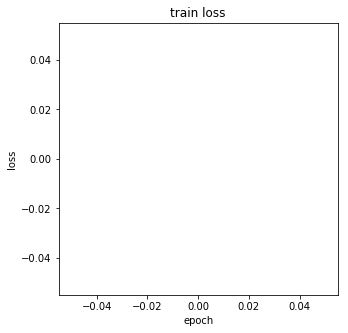

In [27]:
plt.figure(figsize=(5, 5), facecolor="w")
plt.plot(losses_epoch)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("train loss")

In [28]:
x_ = x.to("cpu").numpy()
y_ = y.to("cpu").detach().numpy()
z_ = z.to("cpu").detach().numpy()
label_ = label.to("cpu").numpy()

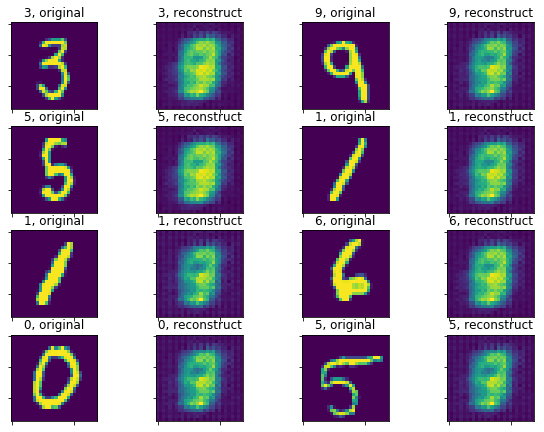

In [29]:
fig = plt.figure(figsize=(10, 15), facecolor="w")
ax = []
display_num = 16
for i in range(int(display_num/2)):
    ax.append(fig.add_subplot(int(display_num/2), 4, 2*i+1))
    ax[2*i].imshow(np.squeeze(x_[i]))
    ax[2*i].set_title(f"{label[i]}, original")
    ax.append(fig.add_subplot(int(display_num/2), 4, 2*i+2))
    ax[2*i+1].imshow(np.squeeze(y_[i]))
    ax[2*i+1].set_title(f"{label[i]}, reconstruct")
for i in range(display_num):    
    ax[i].tick_params(labelbottom=False,
                    labelleft=False,
                    labelright=False,
                    labeltop=False)

#### test

In [60]:
images_ = images.to("cpu").numpy()
outputs_ = outputs.to("cpu").numpy()
labels_ = labels.to("cpu").numpy()
z_test_ = z_test.to("cpu").numpy()[:, :, 0, 0]

In [61]:
z_test_.shape

(10000, 1)

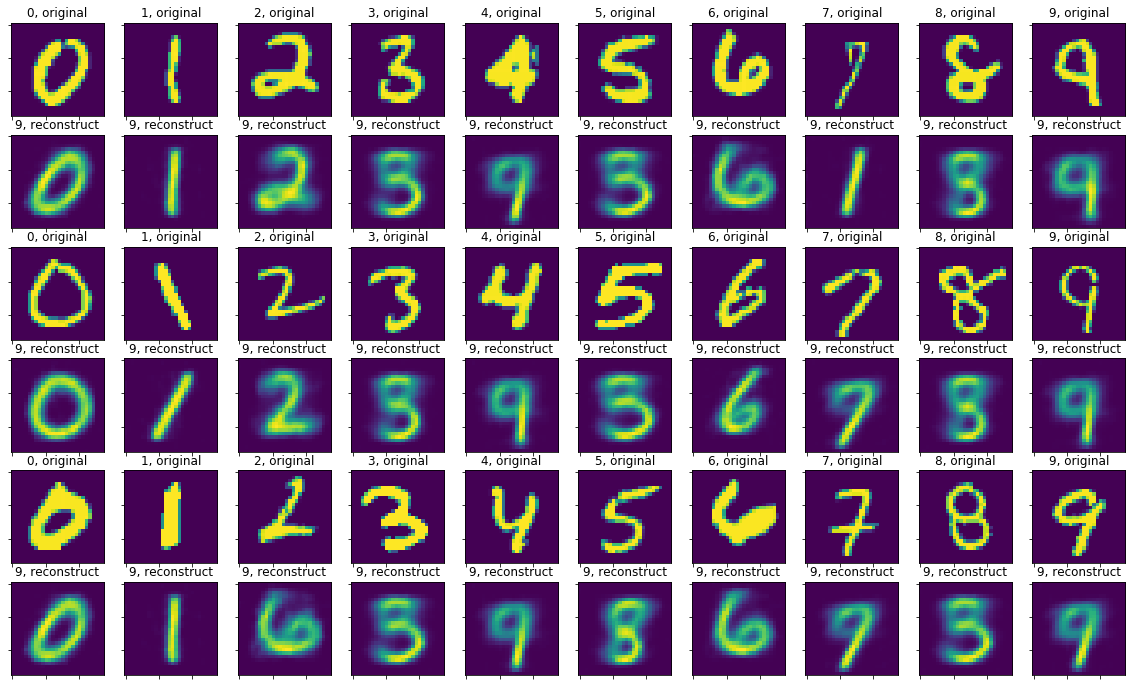

In [62]:
fig = plt.figure(figsize=(20, 12), facecolor="w")
ax = []
display_num = 3
for i in range(display_num):
    rand_int = []
    for j in range(len(classes)):
        index = i*2*len(classes)+j
        ax.append(fig.add_subplot(2*display_num, 10, index+1))
        images_pool = labels.to("cpu").detach().numpy() == classes[j]
        rand_int.append(np.random.randint(0,sum(images_pool)))
        ax[index].imshow(np.squeeze(images_[images_pool,:,:,:][rand_int[j]]))
        ax[index].set_title(f"{classes[j]}, original")
        
    for k in range(len(classes)):
        index = (2*i+1)*len(classes)+k
        ax.append(fig.add_subplot(2*display_num, 10, index+1))
        images_pool = labels.to("cpu").detach().numpy() == classes[k]
        ax[index].imshow(np.squeeze(outputs_[images_pool,:,:,:][rand_int[k]]))
        ax[index].set_title(f"{classes[j]}, reconstruct")

for i in range(display_num*2*len(classes)):
    ax[i].tick_params(labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)

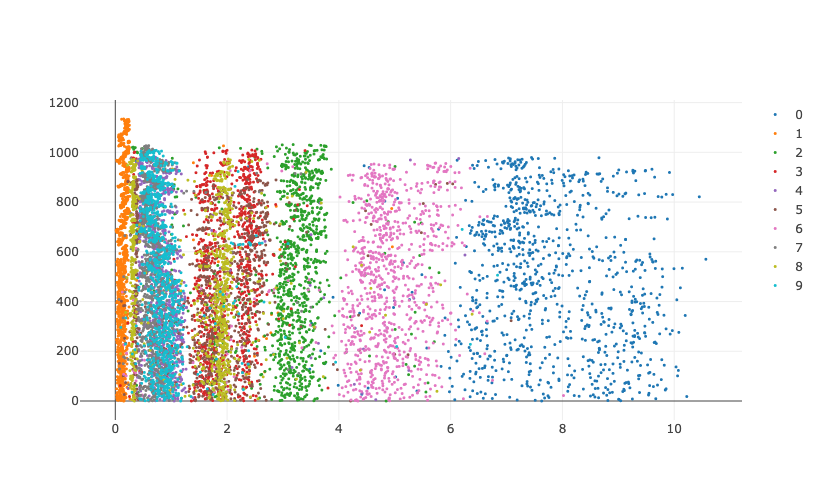

In [63]:
trace = []
for lbl in classes:
    x_ = z_test_[labels_==lbl, 0]
    trace.append(go.Scatter(x=x_, mode="markers", name=f"{lbl}", 
                              marker = dict(size=3)))
layout = go.Layout(width=500, height=500)    
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

In [64]:
save = False
if save:
    torch.save(net.state_dict(), "VAE_1d_model_blog.pth")

## 2次元

In [90]:
epoch_num = 1
z_dim = 2
lr = 0.01

In [91]:
# start net
net, optimizer = init_net(VAE, lr, z_dim)

In [93]:
# start train
net.train()
losses_epoch = []
for epoch in range(epoch_num):
    print(epoch+1)
    losses = []
    for itr, data in enumerate(trainloader):
        x = data[0].to(device)
        label = data[1]

        net.zero_grad()
        y, z = net(x)
        loss = net.loss(x, beta=0.1)
        loss.backward()
        optimizer.step()

        losses.append(loss)
    losses_epoch.append(torch.mean(torch.tensor(losses)))

1


KeyboardInterrupt: 

In [94]:
# start test
outputs, z_test, images, labels = do_test(net, testloader)

### 結果

#### train

Text(0.5, 1.0, 'train loss')

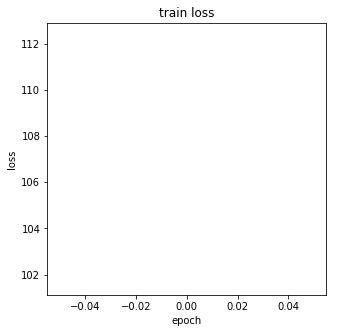

In [71]:
plt.figure(figsize=(5, 5), facecolor="w")
plt.plot(losses_epoch)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("train loss")

In [72]:
x_ = x.to("cpu").numpy()
y_ = y.to("cpu").detach().numpy()
z_ = z.to("cpu").detach().numpy()
label_ = label.to("cpu").numpy()

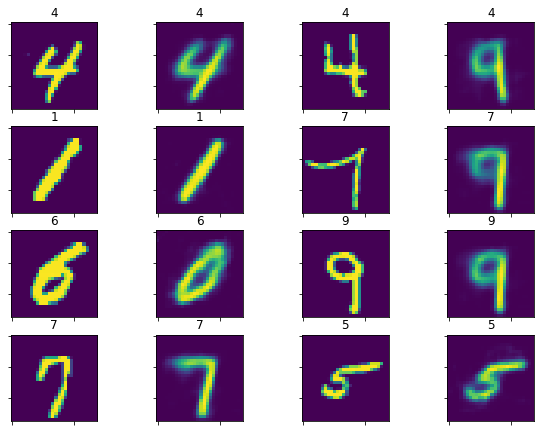

In [73]:
fig = plt.figure(figsize=(10, 15), facecolor="w")
ax = []
display_num = 16
for i in range(int(display_num/2)):
    ax.append(fig.add_subplot(int(display_num/2), 4, 2*i+1))
    ax[2*i].imshow(np.squeeze(x_[i]))
    ax[2*i].set_title(f"{label[i]}")
    ax.append(fig.add_subplot(int(display_num/2), 4, 2*i+2))
    ax[2*i+1].imshow(np.squeeze(y_[i]))
    ax[2*i+1].set_title(f"{label[i]}")

for i in range(display_num):
    ax[i].tick_params(labelbottom=False,
                    labelleft=False,
                    labelright=False,
                    labeltop=False)

#### test

In [95]:
images_ = images.to("cpu").numpy()
outputs_ = outputs.to("cpu").numpy()
labels_ = labels.to("cpu").numpy()
z_test_ = z_test.to("cpu").numpy()[:, :, 0, 0]

In [96]:
z_test_.shape

(10000, 2)

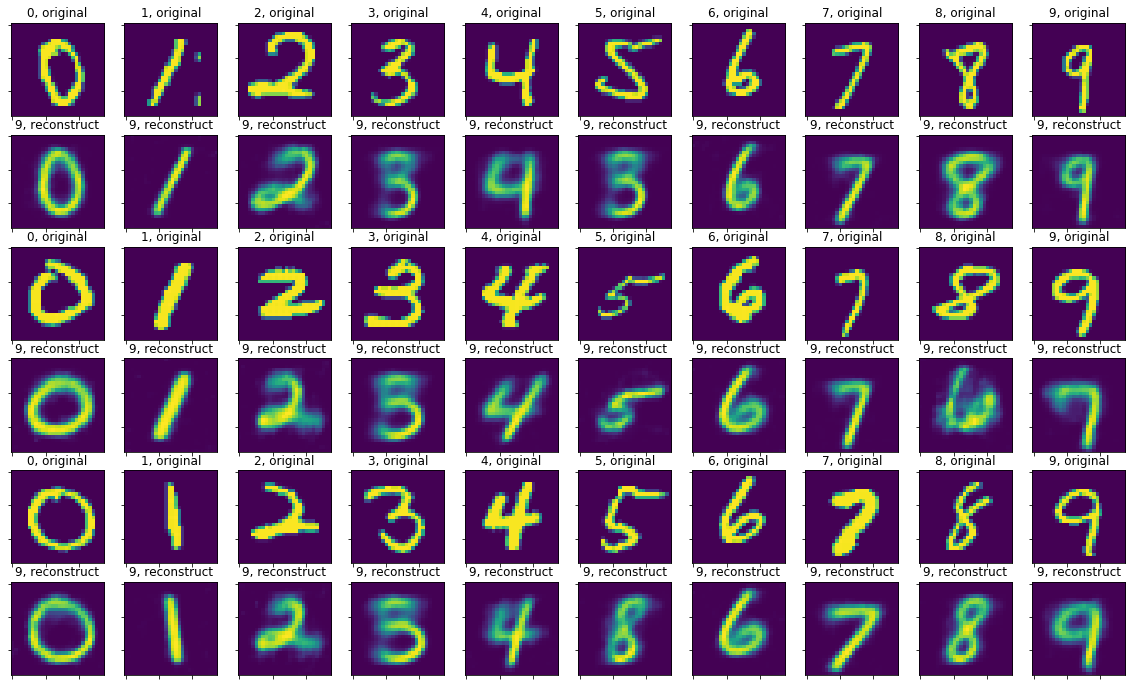

In [98]:
fig = plt.figure(figsize=(20, 12), facecolor="w")
ax = []
display_num = 3
for i in range(display_num):
    rand_int = []
    for j in range(len(classes)):
        index = i*2*len(classes)+j
        ax.append(fig.add_subplot(2*display_num, 10, index+1))
        images_pool = labels.to("cpu").detach().numpy() == classes[j]
        rand_int.append(np.random.randint(0,sum(images_pool)))
        ax[index].imshow(np.squeeze(images_[images_pool,:,:,:][rand_int[j]]))
        ax[index].set_title(f"{classes[j]}, original")
        
    for k in range(len(classes)):
        index = (2*i+1)*len(classes)+k
        ax.append(fig.add_subplot(2*display_num, 10, index+1))
        images_pool = labels.to("cpu").detach().numpy() == classes[k]
        ax[index].imshow(np.squeeze(outputs_[images_pool,:,:,:][rand_int[k]]))
        ax[index].set_title(f"{classes[j]}, reconstruct")
        
for i in range(display_num*2*len(classes)):
    ax[i].tick_params(labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)

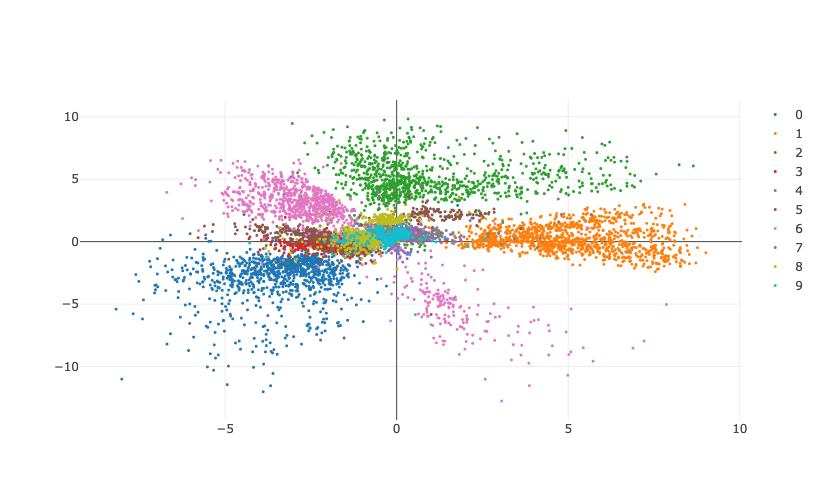

In [77]:
trace = []
for lbl in classes:
    x_ = z_test_[labels_==lbl, 0]
    y_ = z_test_[labels_==lbl, 1]
    trace.append(go.Scatter(x=x_, y=y_, mode="markers", name=f"{lbl}", 
                              marker = dict(size=3)))
layout = go.Layout(width=500, height=500)    
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

In [78]:
save = False
if save:
    torch.save(net.state_dict(), "VAE_2d_model_blog.pth")

## 3次元

In [99]:
epoch_num = 1
z_dim = 3
lr = 0.01

In [100]:
# start net
net, optimizer = init_net(VAE, lr, z_dim)

In [102]:
# train 
plt.figure(figsize=(5, 5), facecolor="w")
net.train()
losses_epoch = []
for epoch in range(epoch_num):
    print(epoch+1)
    losses = []
    for itr, data in enumerate(trainloader):
        x = data[0].to(device)
        label = data[1]

        net.zero_grad()
        y, z = net(x)
        loss = net.loss(x, beta=0.1)
        loss.backward()
        optimizer.step()

        losses.append(loss)
    losses_epoch.append(torch.mean(torch.tensor(losses)))

1


KeyboardInterrupt: 

<Figure size 360x360 with 0 Axes>

In [103]:
# start test
outputs, z_test, images, labels = do_test(net, testloader)

### 結果

#### train

In [ ]:
plt.figure(figsize=(5, 5), facecolor="w")
plt.plot(losses_epoch)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("train loss")

In [ ]:
x_ = x.to("cpu").numpy()
y_ = y.to("cpu").detach().numpy()
z_ = z.to("cpu").detach().numpy()
label_ = label.to("cpu").numpy()

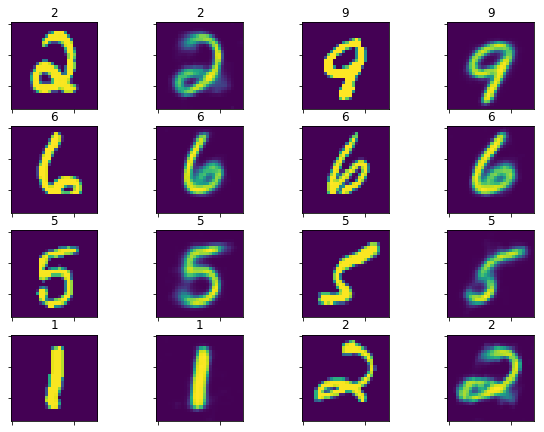

In [86]:
fig = plt.figure(figsize=(10, 15), facecolor="w")
ax = []
display_num = 16
for i in range(int(display_num/2)):
    ax.append(fig.add_subplot(int(display_num/2), 4, 2*i+1))
    ax[2*i].imshow(np.squeeze(x_[i]))
    ax[2*i].set_title(f"{label[i]}")
    ax.append(fig.add_subplot(int(display_num/2), 4, 2*i+2))
    ax[2*i+1].imshow(np.squeeze(y_[i]))
    ax[2*i+1].set_title(f"{label[i]}")
    
for i in range(display_num):
    ax[i].tick_params(labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)

#### test

In [104]:
images_ = images.to("cpu").numpy()
outputs_ = outputs.to("cpu").numpy()
labels_ = labels.to("cpu").numpy()
z_test_ = z_test.to("cpu").numpy()[:, :, 0, 0]

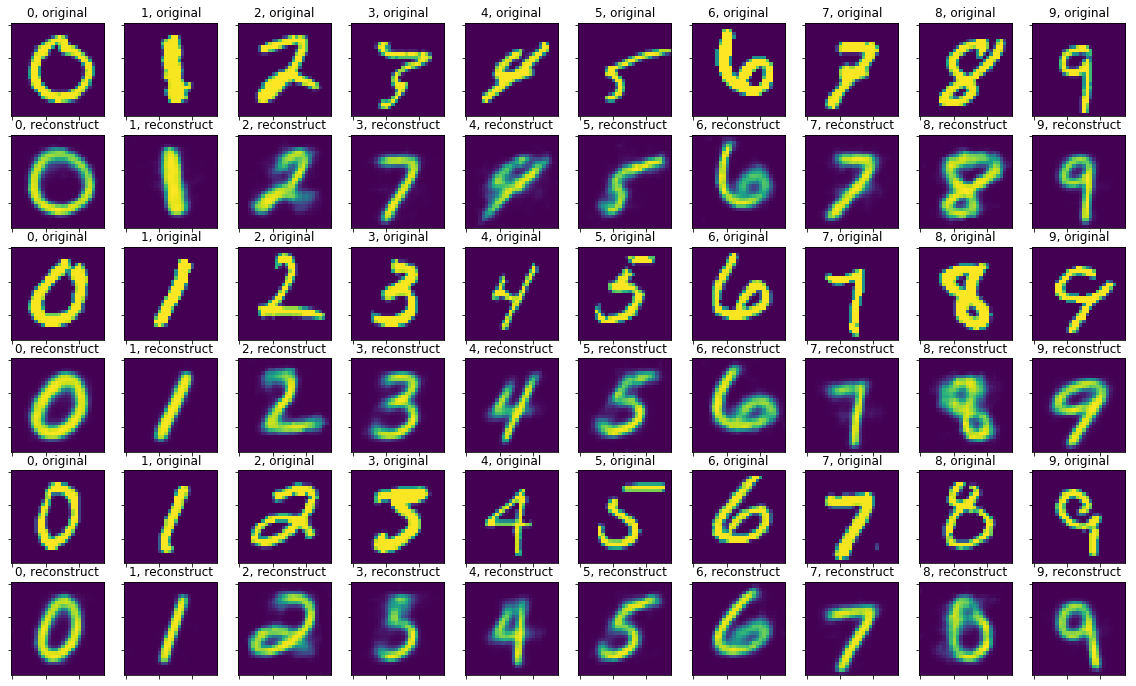

In [105]:
fig = plt.figure(figsize=(20, 12), facecolor="w")
ax = []
display_num = 3
for i in range(display_num):
    rand_int = []
    for j in range(len(classes)):
        index = i*2*len(classes)+j
        ax.append(fig.add_subplot(2*display_num, 10, index+1))
        images_pool = labels.to("cpu").detach().numpy() == classes[j]
        rand_int.append(np.random.randint(0,sum(images_pool)))
        ax[index].imshow(np.squeeze(images_[images_pool,:,:,:][rand_int[j]]))
        ax[index].set_title(f"{classes[j]}, original")
        
    for k in range(len(classes)):
        index = (2*i+1)*len(classes)+k
        ax.append(fig.add_subplot(2*display_num, 10, index+1))
        images_pool = labels.to("cpu").detach().numpy() == classes[k]
        ax[index].imshow(np.squeeze(outputs_[images_pool,:,:,:][rand_int[k]]))
        ax[index].set_title(f"{classes[k]}, reconstruct")
        
for i in range(display_num*2*len(classes)):
    ax[i].tick_params(labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)

In [89]:
save = False
if save:
    torch.save(net.state_dict(), "VAE_3d_model_blog.pth")